# Heavy quarks probing Glasma flux tubes

## Default simulation parameters for the Glasma and the Wong solvers.

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 4      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.3     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 1     # Number of color sheets
g = 2.0           # Running coupling constant	
mu = 0.5           # MV model parameter	
ir = 0.2        # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 15   # Number of test particles

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT, 
    }

## Set environment variables and import all relevant modules.

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
from curraun.wong import init_charge
# Energy density
from curraun.energy import Energy

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Glasma energy density

In [3]:
from tqdm import tqdm
import pickle

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
mv.set_seed(1)
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize energy computation
energy = Energy(s)
ed = []

# masses = [1.27, 4.18]
# form_t = []
# for mass in masses:
    # form_t.append(1/(2*mass)*hbarc/a*DTS)
# taus = [1, int(form_t[0]), int(form_t[1]), maxt]
tau_values = [0.01, 0.05, 0.1, 0.2]
taus = np.round(np.multiply(np.array(tau_values), DTS/a)).astype(int)

with tqdm(total=maxt) as pbar:
    for t in range(1, maxt+1):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        if t in taus:
            # Energy density calculation
            energy.compute()
            # units [Gev / fm]
            units = E0 ** 2 / hbarc 
            et = energy.ET.reshape(N, N)
            e = np.sqrt(et)/t/g**2
            ed.append(e*units)

        pbar.update(1)

output = {}
output['ed'], output['N'], output['L'] = ed, N, L
# max_index = np.unravel_index(ed[0].argmax(), ed[0].shape)
# output['max_index'] = max_index
filename = 'transverse_electric_fields.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

100%|██████████| 307/307 [00:52<00:00,  5.89it/s]


## Simulation routine for evolving the Glasma & solving Wong's equations
Stores positions and momenta for the particles and the energy density of a single Glasma event

In [4]:
from tqdm import tqdm
import pickle

data_ed = pickle.load(open('energy_density.pickle', 'rb'))
max_index = data_ed['max_index']

# Simulation routine
def simulate(p): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    mv.set_seed(314)
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
    angles = 2*np.pi*np.random.rand(ntp)

    for i in range(ntp):
        # Positions
        # Initialize all quarks in the middle
        x0 = [max_index[0], max_index[1], 0]
        # Momenta
        p0 = [0.0, pT * np.cos(angles[i]), pT * np.sin(angles[i]), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)
    xTs = np.zeros((maxt-formt, ntp, 2))
    pTs = np.zeros((maxt-formt, ntp, 2))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                x = wong_solver.x0.copy()
                p = wong_solver.p.copy()
                for ip in range(ntp):
                    xTs[t-formt, ip, :] = [x[ip, 0], x[ip, 1]]
                    pTs[t-formt, ip, :] = [p[ip, 1], p[ip, 2]]

            pbar.update(1)

    return xTs, pTs

## Run for various transverse momenta and quarks

In [5]:
quarks = ['massive', 'charm', 'beauty']
quark_masses = [200, 1.27, 4.18]
pTs = [0.5, 5.0, 10.0]

xT_sim, pT_sim, tau = {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize() + " quark")

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        tau_s = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        xT_sim[tag], pT_sim[tag] = simulate(p)
        tau[tag] = tau_s

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['xT'], output['pT'], output['tau'] = xT_sim, pT_sim, tau
filename = 'flux_tubes.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Massive quark
Transverse momentum 0.5 GeV


100%|██████████| 409/409 [00:52<00:00,  7.82it/s]


Transverse momentum 5.0 GeV


100%|██████████| 409/409 [00:42<00:00,  9.52it/s]


Transverse momentum 10.0 GeV


100%|██████████| 409/409 [00:49<00:00,  8.22it/s]


Charm quark
Transverse momentum 0.5 GeV


100%|██████████| 409/409 [00:39<00:00, 10.23it/s]


Transverse momentum 5.0 GeV


100%|██████████| 409/409 [00:39<00:00, 10.29it/s]


Transverse momentum 10.0 GeV


100%|██████████| 409/409 [00:34<00:00, 11.91it/s]


Beauty quark
Transverse momentum 0.5 GeV


100%|██████████| 409/409 [00:45<00:00,  9.01it/s]


Transverse momentum 5.0 GeV


100%|██████████| 409/409 [00:46<00:00,  8.75it/s]


Transverse momentum 10.0 GeV


100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


## Read data from file using Julia

In [1]:
using Pickle

# data_particles = Pickle.npyload("flux_tubes.pickle")
# quarks, pTs = data_particles["quarks"], data_particles["pTs"]
# xT, p, tau = data_particles["xT"], data_particles["pT"], data_particles["tau"]

data_fields = Pickle.npyload("transverse_electric_fields.pickle")
ed, N, L = data_fields["ed"], data_fields["N"], data_fields["L"]
# max_index = data_fields["max_index"]

(Any[[0.0592569873881294 0.06224889981237988 … 0.054148119714122624 0.05659306403993219; 0.05514325816861162 0.058549689296641796 … 0.053061177548074566 0.05348256212445181; … ; 0.07487415063854493 0.07697490696273238 … 0.06549934746615735 0.07083019787495042; 0.06674106317148706 0.0693080042735881 … 0.05876503413625405 0.0631297494799204], [0.0950498023896064 0.09825792247984991 … 0.08702358485221254 0.09111637910760258; 0.09132758217614524 0.09429356827136698 … 0.08444510424832663 0.08788940115336027; … ; 0.10429908532977313 0.10681111729193077 … 0.09631115475993869 0.10061423082345676; 0.09956879938049544 0.10260211521264957 … 0.09119092727006704 0.09556776775651418], [0.061488819777542295 0.059714981809263316 … 0.0652424436831117 0.0633713436774389; 0.05692894186532347 0.05520870720287285 … 0.06091474511588565 0.058863558209626576; … ; 0.07123019447886635 0.06991243789695015 … 0.07356426585117799 0.07249400293042373; 0.06656059623152714 0.06491313313624758 … 0.0697531521553336 0.06

## Plot using Makie from Julia

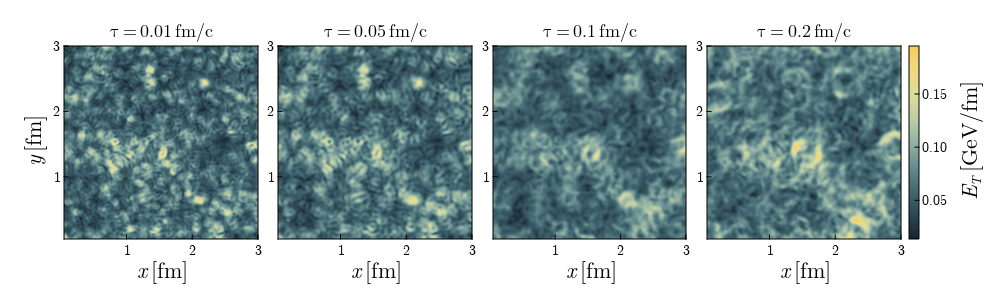

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000d0800d0, 5000.0, 1500.0)


In [21]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[4], starrynight[11]]

fig = Figure(resolution = (1000, 300), font = "CMU Serif")
titles = [L"\tau=0.01\,\mathrm{fm/c}", L"\tau=0.05\,\mathrm{fm/c}", L"\tau=0.1\,\mathrm{fm/c}", L"\tau=0.2\,\mathrm{fm/c}"]
axes_noy = [Axis(fig[1, i], aspect=1, xlabel=L"x\,\mathrm{[fm]}", title=titles[i], titlesize=18,
            xlabelsize = 22, ylabelsize= 22, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 14, yticklabelsize = 14, xlabelpadding = -5) for i in 2:4]
axes = [Axis(fig[1, 1], aspect=1, xlabel=L"x\,\mathrm{[fm]}", ylabel=L"y\,\mathrm{[fm]}", title=titles[1], titlesize=18,
        xlabelsize = 22, ylabelsize= 22, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 14, yticklabelsize = 14, xlabelpadding = -5),
        axes_noy[1], axes_noy[2], axes_noy[3]]

step = 1/16
a = L/N
x, y = a*(1:N), a*(1:N)

for i in 1:4
    interp = interpolate(ed[i], BSpline(Quadratic(Reflect(OnCell()))))
    ed_interp = interp(1:step:N, 1:step:N)

    if i==1
        hmap = heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
        cbar = Colorbar(fig, hmap, label = L"E_T\,\mathrm{[GeV/fm]}", labelsize = 22, width = 10, flipaxis = true,
        ticksize=5, tickalign = 1, ticklabelsize = 14, height = Relative(1))
        fig[1, 5] = cbar
        colgap!(fig.layout, 7)
    else
        heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
    end

    xlims!(axes[i], 0.05, 3)
    ylims!(axes[i], 0.05, 3)
end

display(fig)
save("trans_el_fields.png", fig, px_per_unit = 5.0) 